In [1]:
import os
os.chdir('..')

In [16]:
import numpy as np
import pandas as pd
import random
from scipy.interpolate import PchipInterpolator  # PCHIP 1-D monotonic cubic interpolation
from scipy.interpolate import CubicSpline, UnivariateSpline, InterpolatedUnivariateSpline, splrep, splev, PPoly, interp1d
from scipy.integrate import quad as integrate
from numpy.polynomial.polynomial import Polynomial

from utils.constants import MONTH_IN_SEC
from utils.preprocessing import datetime_index_to_floats
from utils.timing import time_measure
import matplotlib.pyplot as plt


def plot_dist(original_pow: pd.Series, generated_acc: pd.Series):
    f_dates_orig = datetime_index_to_floats(original_pow.index)
    f_dates_orig -= f_dates_orig[0]
    f_dates_gen = datetime_index_to_floats(generated_acc.index)
    f_dates_gen -= f_dates_gen[0]
    united_dates = f_dates_orig.union(f_dates_gen)[1:]

    lin_gen = InterpolatedUnivariateSpline(f_dates_gen, generated_acc.values, k=1)
    gen_der = lin_gen.derivative()

    step_orig = interp1d(
        f_dates_orig, original_pow.values, 'next', bounds_error=False,
        fill_value=(original_pow.values[0], original_pow.values[-1])
    )
    step_gen = interp1d(
        f_dates_gen[1:], gen_der(f_dates_gen[:-1]), 'next', bounds_error=False,
        fill_value=(gen_der(f_dates_gen[0]), gen_der(f_dates_gen[-2])))

    all_values_orig = step_orig(united_dates)
    all_values_gen = step_gen(united_dates)
    diff = all_values_orig - all_values_gen
    
    lot_of_dates = np.linspace(united_dates[0], united_dates[-1], 10001)
    
        
    plt.step(f_dates_orig, step_orig(f_dates_orig), '-', label='orig')
    plt.step(f_dates_gen, step_gen(f_dates_gen), 'o--', label='gen')

    plt.plot(united_dates, diff, '-', label='diff')
    
    plt.legend(loc = 'best')
    plt.axhline(y=0, color='black', linestyle=':')
    plt.fill_between(lot_of_dates, step_orig(lot_of_dates), step_gen(lot_of_dates), color='gray')
    plt.show()
        
#     with time_measure(f'plot_dist'):
#         f_dates_orig = datetime_index_to_floats(original.index)
#         f_dates_orig -= f_dates_orig[0]
#         f_dates_gen = datetime_index_to_floats(generated.index)
#         f_dates_gen -= f_dates_gen[0]
#         united_dates = f_dates_orig.union(f_dates_gen)
#         lin_orig = InterpolatedUnivariateSpline(f_dates_orig, original.values, k=1)
#         lin_gen = InterpolatedUnivariateSpline(f_dates_gen, generated.values, k=1)
#         all_values_orig = lin_orig(united_dates)
#         all_values_gen = lin_gen(united_dates)
#         diff = all_values_orig - all_values_gen
        
        
#         plt.plot(f_dates_orig, original.values, '-', label='orig')
#         plt.plot(f_dates_gen, generated.values, 'o--', label='gen')
# #         plt.plot(united_dates, all_values_orig, '--', label='orig_lin')
# #         plt.plot(united_dates, all_values_gen, ':', label='gen_lin')
        
#         plt.plot(united_dates, diff, '-', label='diff')
# #         plt.plot(united_dates, ppoly(united_dates), 'x:', label='ppoly')
#         plt.legend(loc = 'best')
#         plt.axhline(y=0, color='black', linestyle=':')
#         plt.fill_between(united_dates, all_values_orig, all_values_gen, color='gray')
#         plt.show()
        
        


In [4]:
import numpy as np
from nilmtk import STATS_CACHE

from utils.constants import DatasetType, DAY_IN_SEC
from utils.data_reading import clean_and_store_data, read_cleaned_data, \
    convert_to_nilmtk_format, store_processed_stable_periods, \
    get_full_keys_of_stable_periods, read_stable_periods, build_full_key, read_stable_period
from utils.preprocessing import generate_sync_signals, get_stable_periods, \
    interpolate_missed_data, generate_async_signals, reformat_to_accumulated, generate_async_signals_by_point_count
from utils.timing import time_measure
from utils.visualization import plot_sync_async_comparison

STATS_CACHE.store.close()


DS = DatasetType.IDEAL
DURATION = DAY_IN_SEC
MAX_GAP = 10
# TIME_DELTA = 5

full_keys = get_full_keys_of_stable_periods(DS, build_full_key('', DURATION, MAX_GAP, 0))
accumulated = read_stable_periods(DS, [full_keys[0]])[0]
power = read_stable_period(DS, full_keys[0], power_mode=True)

[reading 1 stable periods of IDEAL] finished in 0m 0.02s


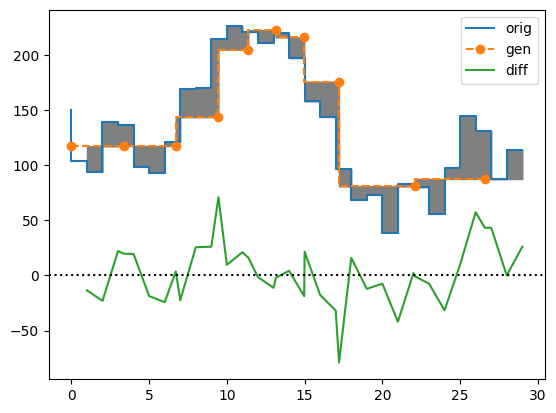

In [40]:
signals = [150]
step = random.random()
for i in range(30-1):
    if random.random() > 0:
        step = random.random() - 0.5
    signals.append(signals[-1] + step * 100)
power_part = pd.Series(signals, index=power.index[:30])
point_count = 10
async_signals = generate_async_signals_by_point_count(reformat_to_accumulated(power_part), point_count)
plot_dist(power_part, async_signals)